In [1]:
# db_config.py

import pymysql

def get_connection():
    return pymysql.connect(
        host='localhost',
        user='root',
        password='kwon0822@',
        db='culture_db',
        charset='utf8mb4',
        cursorclass=pymysql.cursors.DictCursor
    )


In [2]:
# main.py

import pandas as pd
from db_config import get_connection

# MySQL 연결
conn = get_connection()

# 각 테이블을 pandas DataFrame으로 불러오기
members_df = pd.read_sql("SELECT * FROM member", conn)
contents_df = pd.read_sql("SELECT * FROM content_detail", conn)
likes_df = pd.read_sql("SELECT * FROM content_favorite", conn)
region_df = pd.read_sql("SELECT * FROM region_coords", conn)
subcategory_df = pd.read_sql("SELECT * FROM content_sub_category", conn)
category_df = pd.read_sql("SELECT * FROM content_category", conn)

# 연결 종료
conn.close()

C:\Users\pc\AppData\Local\Temp\ipykernel_13072\1835336651.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  members_df = pd.read_sql("SELECT * FROM member", conn)
C:\Users\pc\AppData\Local\Temp\ipykernel_13072\1835336651.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  contents_df = pd.read_sql("SELECT * FROM content_detail", conn)
C:\Users\pc\AppData\Local\Temp\ipykernel_13072\1835336651.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  likes_df = pd.read_sql("SELECT * FROM content_favorite", conn)
C:\Users\pc\Ap

In [3]:
import pandas as pd
import random
from datetime import datetime, timedelta
from db_config import get_connection

# 테이블 불러오기
conn = get_connection()
members_df = pd.read_sql("SELECT * FROM member", conn)
contents_df = pd.read_sql("SELECT * FROM content_detail", conn)
subcategory_df = pd.read_sql("SELECT * FROM content_sub_category", conn)
conn.close()

# 1. 추천 세트 정의
recommend_sets = [
    {'keyword1': '야외', 'keyword2': '활동적', 'keyword3': '운동', 'target': ['축구', '야구', '농구']},
    {'keyword1': '야외', 'keyword2': '감성적', 'keyword3': '자연', 'target': ['체험형']},
    {'keyword1': '실내', 'keyword2': '감성적', 'keyword3': '음악', 'target': ['콘서트']},
    {'keyword1': '실내', 'keyword2': '감성적', 'keyword3': '예술', 'target': ['뮤지컬', '연극']},
    {'keyword1': '실내', 'keyword2': '정적', 'keyword3': '독서', 'target': ['기획전']},
    {'keyword1': '실내', 'keyword2': '정적', 'keyword3': '조용함', 'target': ['연극']},
    {'keyword1': '야외', 'keyword2': '활동적', 'keyword3': '열정적', 'target': ['대학 축제', '지역 축제']},
    {'keyword1': '실내', 'keyword2': '활동적', 'keyword3': '쇼핑', 'target': ['패션']},
    {'keyword1': '실내', 'keyword2': '감성적', 'keyword3': '북적임', 'target': ['팝컬처']},
    {'keyword1': '야외', 'keyword2': '감성적', 'keyword3': '음식', 'target': ['음식']},
]

# 2. 중분류 이름별 콘텐츠 ID 매핑
merged = pd.merge(contents_df, subcategory_df, left_on='content_sub_category_id', right_on='id', suffixes=('', '_sub'))
subcategory_map = merged.groupby('name')['id'].apply(list).to_dict()

# 3. 사용자별 찜 콘텐츠 생성
all_content_ids = contents_df['id'].tolist()
new_likes = []

for _, user in members_df.iterrows():
    uid = user['id']
    k1, k2, k3 = user['keyword1'], user['keyword2'], user['keyword3']

    # 세트 매칭 여부 확인
    matched_set = None
    for s in recommend_sets:
        if s['keyword1'] == k1 and s['keyword2'] == k2 and s['keyword3'] == k3:
            matched_set = s
            break

    if matched_set:
        # 세트 조건 만족
        target_cids = []
        for cat in matched_set['target']:
            target_cids.extend(subcategory_map.get(cat, []))
        target_cids = list(set(target_cids))

        sample_target = random.sample(target_cids, min(len(target_cids), random.randint(70, 80)))
        remaining = random.sample([cid for cid in all_content_ids if cid not in sample_target], 100 - len(sample_target))
        sampled = sample_target + remaining

    else:
        # 세트 조건 불만족: 전체에서 랜덤
        sampled = random.sample(all_content_ids, 100)

    # created_at 설정
    for cid in sampled:
        rand_day = random.randint(0, 30)
        rand_sec = random.randint(0, 86400)
        rand_time = datetime.now() - timedelta(days=rand_day, seconds=rand_sec)
        new_likes.append({
            'member_id': uid,
            'content_detail_id': cid,
            'created_at': rand_time
        })

# 4. MySQL 삽입
likes_df = pd.DataFrame(new_likes)
conn = get_connection()
cursor = conn.cursor()

cursor.execute("TRUNCATE TABLE content_favorite")

insert_sql = """
INSERT INTO content_favorite (member_id, content_detail_id, created_at)
VALUES (%s, %s, %s)
"""

data_to_insert = [
    (row['member_id'], row['content_detail_id'], row['created_at'].strftime('%Y-%m-%d %H:%M:%S'))
    for _, row in likes_df.iterrows()
]

cursor.executemany(insert_sql, data_to_insert)
conn.commit()

cursor.execute("SELECT COUNT(*) AS count FROM content_favorite")
count = cursor.fetchone()[0]  # 정수 인덱스로 수정
print(f"✅ 총 {count}개의 데이터가 저장되었습니다.")  # 기대값: 5200


cursor.close()
conn.close()


C:\Users\pc\AppData\Local\Temp\ipykernel_13072\2242545784.py:8: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  members_df = pd.read_sql("SELECT * FROM member", conn)
C:\Users\pc\AppData\Local\Temp\ipykernel_13072\2242545784.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  contents_df = pd.read_sql("SELECT * FROM content_detail", conn)
C:\Users\pc\AppData\Local\Temp\ipykernel_13072\2242545784.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  subcategory_df = pd.read_sql("SELECT * FROM content_sub_category", conn)


✅ 총 5200개의 데이터가 저장되었습니다.


In [4]:
# 데이터 확인
print("✅ members_df:", members_df.shape)
print("✅ contents_df:", contents_df.shape)
print("✅ likes_df:", likes_df.shape)
print("✅ region_df:", region_df.shape)
print("✅ subcategory_df:", subcategory_df.shape)
print("✅ category_df:", category_df.shape)

✅ members_df: (52, 12)
✅ contents_df: (1324, 12)
✅ likes_df: (5200, 3)
✅ region_df: (25, 3)
✅ subcategory_df: (14, 3)
✅ category_df: (5, 2)


In [5]:
# 사용자 ID와 콘텐츠 ID 추출
user_ids = members_df['id'].unique()
content_ids = contents_df['id'].unique()

# 모든 조합 생성
full_df = pd.DataFrame([(u, c) for u in user_ids for c in content_ids], columns=['member_id', 'content_detail_id'])

print("✅ full_df 생성 완료:", full_df.shape)
print(full_df.head(10))


✅ full_df 생성 완료: (68848, 2)
   member_id  content_detail_id
0          1                  1
1          1                  2
2          1                  3
3          1                  4
4          1                  5
5          1                  6
6          1                  7
7          1                  8
8          1                  9
9          1                 10


In [6]:
from datetime import datetime

# 기준 날짜: 가장 최근 날짜
max_date = likes_df['created_at'].max()

# time_score 계산: 날짜 차이 기반 (최근일수록 점수 높음)
likes_df = likes_df.copy()
likes_df['time_score'] = likes_df['created_at'].apply(lambda d: 1 / (1 + (max_date - d).days))

print("✅ time_score 예시:")
likes_df[['member_id', 'content_detail_id', 'created_at', 'time_score']].head(200)


✅ time_score 예시:


,member_id,content_detail_id,created_at,time_score
0,1,128,2025-05-17 20:41:32.105409,0.052632
1,1,402,2025-05-13 16:10:45.105409,0.043478
2,1,658,2025-06-04 12:20:39.105409,1.000000
3,1,889,2025-05-27 11:07:27.105409,0.111111
4,1,1071,2025-05-12 06:29:49.105409,0.041667
...,...,...,...,...
195,2,797,2025-05-06 01:40:55.105409,0.033333
196,2,864,2025-05-25 17:41:47.105409,0.090909
197,2,390,2025-05-09 21:49:38.105409,0.037037
198,2,289,2025-05-15 04:21:16.105409,0.047619


In [7]:
# full_df: (member_id, content_detail_id)
# likes_df: (member_id, content_detail_id, time_score)

# 병합
merged_df = pd.merge(
    full_df,
    likes_df[['member_id', 'content_detail_id', 'time_score']],
    on=['member_id', 'content_detail_id'],
    how='left'
)

# label 생성: 찜했으면 1, 아니면 0
merged_df['label'] = merged_df['time_score'].apply(lambda x: 1 if pd.notnull(x) else 0)

# time_score 없으면 0으로 채움
merged_df['time_score'] = merged_df['time_score'].fillna(0)

# 사용자별 평균 time_score 계산
user_time_score_map = likes_df.groupby('member_id')['time_score'].mean().to_dict()

# label == 0인 경우 사용자 평균으로 대체
merged_df['time_score'] = merged_df.apply(
    lambda row: user_time_score_map.get(row['member_id'], 0) if (row['label'] == 0 and row['time_score'] == 0) else row['time_score'],
    axis=1
)

print("✅ 병합 후 full_df (with label + time_score):", merged_df.shape)


✅ 병합 후 full_df (with label + time_score): (68848, 4)


In [8]:
# time_score가 0보다 큰 경우만 필터
nonzero_time_score_df = merged_df[merged_df['time_score'] > 0]

# time_score가 0이 아닌 예시 데이터
print("✅ time_score > 0인 예시:")
print(nonzero_time_score_df[['member_id', 'content_detail_id', 'time_score']].head(50))


✅ time_score > 0인 예시:
    member_id  content_detail_id  time_score
0           1                  1    0.186431
1           1                  2    0.186431
2           1                  3    0.186431
3           1                  4    0.186431
4           1                  5    0.186431
5           1                  6    0.186431
6           1                  7    0.186431
7           1                  8    0.186431
8           1                  9    0.186431
9           1                 10    0.111111
10          1                 11    0.186431
11          1                 12    0.186431
12          1                 13    0.186431
13          1                 14    0.186431
14          1                 15    0.186431
15          1                 16    0.186431
16          1                 17    0.186431
17          1                 18    0.186431
18          1                 19    0.186431
19          1                 20    0.186431
20          1                 21 

In [9]:
def extract_region(text):
    try:
        if ' ' in text:
            for part in text.split():
                if part.endswith('구'):
                    return part
    except:
        return None
    return None


In [10]:
# 사용자 위치 → 구 추출
members_df['region'] = members_df['location'].apply(extract_region)

# 콘텐츠 주소 → 구 추출
contents_df['region_content'] = contents_df['address'].apply(extract_region)


In [11]:
# 서울시 각 구에 대한 위도/경도 매핑
region_coords = {
    row['region']: (row['lat'], row['lon'])
    for _, row in region_df.iterrows()
}


In [12]:
from math import radians, cos, sin, sqrt, atan2
import numpy as np

# 위도/경도로 거리 계산 (단위: km)
def calculate_distance_km(lat1, lon1, lat2, lon2):
    R = 6371  # 지구 반지름 (km)
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# 안전하게 구 정보가 없는 경우 NaN 반환
def safe_calculate_distance(row):
    loc1 = region_coords.get(row['region'])
    loc2 = region_coords.get(row['region_content'])
    if loc1 is None or loc2 is None:
        return np.nan
    return calculate_distance_km(loc1[0], loc1[1], loc2[0], loc2[1])


In [13]:
# member_id에 해당하는 사용자 region 가져오기
members_region = members_df[['id', 'region']].rename(columns={'id': 'member_id'})

# content_detail_id에 해당하는 콘텐츠 region 가져오기
contents_region = contents_df[['id', 'region_content']].rename(columns={'id': 'content_detail_id'})

# 사용자 지역 merge
merged_df = merged_df.merge(members_region, on='member_id', how='left')

# 콘텐츠 지역 merge
merged_df = merged_df.merge(contents_region, on='content_detail_id', how='left')


In [14]:
# 거리 계산 실행
merged_df['distance'] = merged_df.apply(safe_calculate_distance, axis=1)

# 확인용 출력
print("✅ 거리 계산 완료 예시:")
merged_df[['member_id', 'content_detail_id', 'region', 'region_content', 'distance']].dropna().head()


✅ 거리 계산 완료 예시:


,member_id,content_detail_id,region,region_content,distance
0,1,1,강남구,영등포구,13.356090
1,1,2,강남구,종로구,8.654212
2,1,3,강남구,종로구,8.654212
3,1,4,강남구,서초구,3.960622
4,1,5,강남구,중구,6.794637


In [15]:
from gensim.models import Word2Vec

# 사용자 성향 키워드 → 하나의 리스트로 만들기
sentences = members_df[['keyword1', 'keyword2', 'keyword3']].values.tolist()

# gensim Word2Vec 학습
w2v_model = Word2Vec(sentences, vector_size=5, window=2, min_count=1, sg=1, seed=42)

print("✅ Word2Vec 학습 완료. 예시 단어 벡터:")
print("  '야외' →", w2v_model.wv['야외'])


✅ Word2Vec 학습 완료. 예시 단어 벡터:
  '야외' → [-0.16438909  0.10998178  0.06237742 -0.02416413 -0.02657798]


In [16]:
for word in w2v_model.wv.index_to_key:
    print(word, "→", w2v_model.wv[word])


야외 → [-0.16438909  0.10998178  0.06237742 -0.02416413 -0.02657798]
활동적 → [ 0.1438518  -0.16592482  0.07866723 -0.11910311 -0.16229603]
정적 → [0.01070778 0.19013649 0.09427096 0.10451538 0.08696517]
실내 → [ 0.11485735  0.005379   -0.14879377  0.13641682 -0.01986728]
예술 → [ 0.00031403 -0.05171847 -0.1269416   0.17084599  0.11254993]
쇼핑 → [ 0.05752504 -0.03906542  0.12906344  0.01817818 -0.02258408]
감성적 → [-0.0199436  -0.10925782 -0.16345526  0.02181343  0.15520282]
조용함 → [-0.17454915  0.14344765  0.13103095 -0.08923542  0.0526685 ]
자연 → [-0.1339442   0.10324     0.08023077 -0.05819103 -0.17280182]
열정적 → [ 0.18818228 -0.02156172  0.15739849  0.07121501  0.11138133]
독서 → [ 0.10377881 -0.12213688 -0.05449493 -0.0133659  -0.00081363]
음악 → [-0.1825425   0.01852793 -0.13832943  0.09726968  0.07331139]
운동 → [ 0.1690732   0.09789157 -0.05338035  0.18702245 -0.0356486 ]
북적임 → [-0.06966987  0.16221431 -0.05181613 -0.16946273 -0.01217768]


In [17]:
# 사용자별 벡터 저장 리스트
user_vecs = []

for _, row in members_df.iterrows():
    keywords = [row['keyword1'], row['keyword2'], row['keyword3']]
    vectors = [w2v_model.wv[word] for word in keywords if word in w2v_model.wv]

    if vectors:
        avg_vec = np.mean(vectors, axis=0)
    else:
        avg_vec = np.zeros(w2v_model.vector_size)

    vec_dict = {'member_id': row['id']}
    for i, val in enumerate(avg_vec):
        vec_dict[f'w2v_feature_{i}'] = val

    user_vecs.append(vec_dict)

# DataFrame으로 변환
user_w2v_df = pd.DataFrame(user_vecs)

print("✅ 사용자 Word2Vec 임베딩 생성 완료:")
user_w2v_df.head()


✅ 사용자 Word2Vec 임베딩 생성 완료:


,member_id,w2v_feature_0,w2v_feature_1,w2v_feature_2,w2v_feature_3,w2v_feature_4
0,1,-0.051494,0.015766,0.073758,-0.067153,-0.120559
1,2,0.094365,-0.041814,-0.051617,0.076482,0.082239
2,3,0.008415,0.019445,-0.121355,-0.003744,0.041053
3,4,0.086341,-0.070755,-0.065689,0.062720,-0.023204
4,5,-0.074450,0.154111,0.034944,-0.029704,0.016070


In [18]:
from numpy.linalg import norm

vec1 = user_w2v_df.loc[user_w2v_df['member_id'] == 1].iloc[0, 1:].values
vec2 = user_w2v_df.loc[user_w2v_df['member_id'] == 2].iloc[0, 1:].values
similarity = vec1 @ vec2 / (norm(vec1) * norm(vec2))  # 코사인 유사도
print(f"1번 vs 2번 사용자 코사인 유사도: {similarity:.4f}")


1번 vs 2번 사용자 코사인 유사도: -0.9148


In [19]:
# Word2Vec 임베딩 벡터를 merged_df에 member_id 기준으로 병합
merged_df = pd.merge(merged_df, user_w2v_df, on='member_id', how='left')

print("✅ merged_df에 Word2Vec 임베딩 벡터 추가 완료:")
merged_df[[col for col in merged_df.columns if col.startswith('w2v_feature_')]].head()


✅ merged_df에 Word2Vec 임베딩 벡터 추가 완료:


,w2v_feature_0,w2v_feature_1,w2v_feature_2,w2v_feature_3,w2v_feature_4
0,-0.051494,0.015766,0.073758,-0.067153,-0.120559
1,-0.051494,0.015766,0.073758,-0.067153,-0.120559
2,-0.051494,0.015766,0.073758,-0.067153,-0.120559
3,-0.051494,0.015766,0.073758,-0.067153,-0.120559
4,-0.051494,0.015766,0.073758,-0.067153,-0.120559


In [20]:
# member_id 기준으로 gender 컬럼 붙이기
members_gender = members_df[['id', 'gender']].rename(columns={'id': 'member_id'})
merged_df = merged_df.merge(members_gender, on='member_id', how='left')


In [21]:
from sklearn.preprocessing import OneHotEncoder

# 인코딩할 범주형 컬럼 지정
cat_cols = ['gender', 'region', 'region_content']

# null 값 제거 (인코딩 에러 방지)
merged_df = merged_df.dropna(subset=cat_cols)

# One-Hot Encoding 수행
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(merged_df[cat_cols])

# DataFrame으로 변환
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols))
encoded_df.index = merged_df.index  # 인덱스 정렬 유지


In [22]:
# Word2Vec 임베딩 컬럼 목록
w2v_cols = [col for col in merged_df.columns if col.startswith('w2v_feature_')]

# age, distance, time_score 컬럼도 포함
if 'age' not in merged_df.columns:
    members_age = members_df[['id', 'age']].rename(columns={'id': 'member_id'})
    merged_df = merged_df.merge(members_age, on='member_id', how='left')

# 사용할 수치형 컬럼
num_cols = ['age', 'distance', 'time_score'] + w2v_cols

# 수치형 feature만 추출
numeric_df = merged_df[num_cols].copy()
numeric_df.index = merged_df.index


In [23]:
# 입력 X: One-Hot Encoding + 수치형 feature 결합
X = pd.concat([encoded_df, numeric_df], axis=1)

# 정답 레이블 y: label 컬럼
y = merged_df['label'].copy()

print("✅ 최종 입력 X shape:", X.shape)
print("✅ 정답 레이블 y shape:", y.shape)
print("✅ y 값 분포:")
y.value_counts()


✅ 최종 입력 X shape: (68848, 40)
✅ 정답 레이블 y shape: (68848,)
✅ y 값 분포:


label
0    63648
1     5200
Name: count, dtype: int64

In [24]:
from sklearn.model_selection import train_test_split

# 학습 80% / 검증 20%로 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ 학습 세트:", X_train.shape)
print("✅ 검증 세트:", X_val.shape)


✅ 학습 세트: (55078, 40)
✅ 검증 세트: (13770, 40)


In [25]:
# ✅ 콘텐츠별 총 찜 수
content_like_counts = likes_df['content_detail_id'].value_counts().to_dict()
merged_df['content_total_likes'] = merged_df['content_detail_id'].map(content_like_counts).fillna(0)

# ✅ 사용자별 총 찜 수
member_like_counts = likes_df['member_id'].value_counts().to_dict()
merged_df['member_total_likes'] = merged_df['member_id'].map(member_like_counts).fillna(0)


In [26]:
# y는 찜 여부 (1 = 찜, 0 = 안 찜)
y = merged_df['label']

# 모델 입력 feature
num_cols = ['age', 'distance', 'time_score', 'content_total_likes', 'member_total_likes']
w2v_cols = [col for col in merged_df.columns if col.startswith('w2v_feature_')]
onehot_cols = [col for col in merged_df.columns if col.startswith('gender_') or col.startswith('location_') or col.startswith('category_') or col.startswith('region_')]

X = merged_df[num_cols + w2v_cols + onehot_cols]

# 문자열(object) 타입 컬럼 제거
X = X.select_dtypes(include=['int64', 'float64', 'bool'])


In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 모델 학습
model = XGBClassifier(n_estimators=100, eval_metric='logloss')
model.fit(X_train, y_train)

# 전체 데이터에 대해 예측 score 계산
merged_df['score'] = model.predict_proba(X)[:, 1]


In [28]:
# 각 사용자별 label==1 중 score가 가장 높은 콘텐츠 추출
top_positive = (
    merged_df[merged_df['label'] == 1]
    .sort_values(['member_id', 'score'], ascending=[True, False])
    .groupby('member_id')
    .first()
    .reset_index()
    .rename(columns={'content_detail_id': 'positive_content_id'})
)

print("✅ 사용자별 Top 찜 콘텐츠 추출 완료")


✅ 사용자별 Top 찜 콘텐츠 추출 완료


In [29]:
top_positive.head()

,member_id,positive_content_id,time_score,label,region,region_content,distance,w2v_feature_0,w2v_feature_1,w2v_feature_2,w2v_feature_3,w2v_feature_4,gender,age,content_total_likes,member_total_likes,score
0,1,311,0.090909,1,강남구,영등포구,13.356090,-0.051494,0.015766,0.073758,-0.067153,-0.120559,MALE,19,8.0,100,0.999871
1,2,138,0.062500,1,송파구,용산구,10.443336,0.094365,-0.041814,-0.051617,0.076482,0.082239,FEMALE,29,6.0,100,0.999856
2,3,21,0.040000,1,종로구,강동구,13.631068,0.008415,0.019445,-0.121355,-0.003744,0.041053,FEMALE,34,7.0,100,0.999848
3,4,51,0.038462,1,송파구,서대문구,16.618466,0.086341,-0.070755,-0.065689,0.062720,-0.023204,MALE,29,9.0,100,0.999856
4,5,21,0.043478,1,마포구,강동구,20.007045,-0.074450,0.154111,0.034944,-0.029704,0.016070,FEMALE,28,7.0,100,0.999606


In [30]:
from gensim.models import Word2Vec
import numpy as np

# ✅ 1. subcategory를 하나의 문장 리스트로 변환
contents_df['subcategory_tokens'] = contents_df['content_sub_category_id'].astype(str).apply(lambda x: [f"sub_{x}"])

# ✅ 2. Word2Vec 학습
subcategory_sentences = contents_df['subcategory_tokens'].tolist()
subcategory_w2v_model = Word2Vec(subcategory_sentences, vector_size=5, window=2, min_count=1, sg=1, seed=42)

# ✅ 3. 각 콘텐츠에 대해 평균 벡터 생성
content_vecs = []
for _, row in contents_df.iterrows():
    tokens = row['subcategory_tokens']
    vectors = [subcategory_w2v_model.wv[token] for token in tokens if token in subcategory_w2v_model.wv]
    avg_vec = np.mean(vectors, axis=0) if vectors else np.zeros(5)
    vec_dict = {'content_detail_id': row['id']}
    for i, val in enumerate(avg_vec):
        vec_dict[f'cvec_{i}'] = val
    content_vecs.append(vec_dict)

content_w2v_df = pd.DataFrame(content_vecs)


In [31]:
import re

# 소문자 + 특수문자 제거 + 공백 기준 토큰화
contents_df['tokens'] = contents_df['content_name'].str.lower().apply(
    lambda x: re.sub(r'[^\w\s]', '', x).split() if isinstance(x, str) else []
)


In [32]:
from gensim.models import Word2Vec

# 학습용 문장 리스트
content_sentences = contents_df['tokens'].tolist()

# Word2Vec 학습
content_w2v_model = Word2Vec(
    content_sentences, vector_size=5, window=2, min_count=1, sg=1, seed=42
)


In [33]:
content_vecs = []

for _, row in contents_df.iterrows():
    tokens = row['tokens']
    vectors = [content_w2v_model.wv[word] for word in tokens if word in content_w2v_model.wv]

    avg_vec = np.mean(vectors, axis=0) if vectors else np.zeros(5)

    vec_dict = {'content_detail_id': row['id']}
    for i, val in enumerate(avg_vec):
        vec_dict[f'cvec_{i}'] = val
    content_vecs.append(vec_dict)

content_w2v_df = pd.DataFrame(content_vecs)


In [34]:
merged_df = merged_df.merge(content_w2v_df, on='content_detail_id', how='left')


In [35]:
from sklearn.metrics.pairwise import cosine_similarity

# 콘텐츠 벡터 컬럼 지정
content_vec_cols = [col for col in merged_df.columns if col.startswith('cvec_')]

# 사용자별로 label==1 중 가장 score 높은 콘텐츠 찾기
top_positive = (
    merged_df[merged_df['label'] == 1]
    .sort_values(['member_id', 'score'], ascending=[True, False])
    .groupby('member_id')
    .first()
    .reset_index()
    .rename(columns={'content_detail_id': 'positive_content_id'})
)

# 추천 함수: 콘텐츠 벡터 기반
def recommend_by_content_similarity(row):
    user_id = row['member_id']
    pos_id = row['positive_content_id']

    # 후보: label==0인 콘텐츠 중에서만
    candidates = merged_df[(merged_df['member_id'] == user_id) & (merged_df['label'] == 0)].copy()

    # positive 콘텐츠 벡터
    pos_vec = merged_df[
        (merged_df['member_id'] == user_id) & 
        (merged_df['content_detail_id'] == pos_id)
    ][content_vec_cols].values

    cand_vecs = candidates[content_vec_cols].values

    # cosine 유사도 계산
    similarities = cosine_similarity(pos_vec, cand_vecs)[0]
    candidates['similarity'] = similarities

    # Top-3 추천
    top_n = candidates.sort_values('similarity', ascending=False).head(3)
    return top_n[['member_id', 'content_detail_id', 'score', 'similarity']]

# 전체 사용자에 대해 추천 생성
final_recommendations = pd.concat(
    [recommend_by_content_similarity(row) for _, row in top_positive.iterrows()],
    ignore_index=True
)

final_recommendations.head(10)


,member_id,content_detail_id,score,similarity
0,1,790,0.000093,0.968154
1,1,612,0.000093,0.952945
2,1,1254,0.000098,0.952877
3,2,254,0.000020,0.960139
4,2,1151,0.000018,0.945040
5,2,998,0.000023,0.943138
6,3,391,0.000014,0.968584
7,3,928,0.000016,0.965012
8,3,1108,0.000021,0.940227
9,4,1022,0.000021,0.956500


In [36]:
# 가중 평균 점수 계산
final_recommendations['final_score'] = (
    0.6 * final_recommendations['score'] +
    0.4 * final_recommendations['similarity']
)

# 사용자별 Top-3 추출
top_n = (
    final_recommendations
    .sort_values(['member_id', 'final_score'], ascending=[True, False])
    .groupby('member_id')
    .head(3)
    .reset_index(drop=True)
)

# 출력
top_n.head(10)


,member_id,content_detail_id,score,similarity,final_score
0,1,790,0.000093,0.968154,0.387317
1,1,612,0.000093,0.952945,0.381234
2,1,1254,0.000098,0.952877,0.381210
3,2,254,0.000020,0.960139,0.384068
4,2,1151,0.000018,0.945040,0.378027
5,2,998,0.000023,0.943138,0.377269
6,3,391,0.000014,0.968584,0.387442
7,3,928,0.000016,0.965012,0.386015
8,3,1108,0.000021,0.940227,0.376103
9,4,1022,0.000021,0.956500,0.382613


In [37]:
# time_score 가중치 축소
merged_df['time_score'] = merged_df['time_score'] * 0.1


In [38]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# X, y 재정의
X = pd.concat([encoded_df, numeric_df], axis=1)
y = merged_df['label'].copy()

# 학습/검증 세트 분리
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 클래스 불균형 보정
neg = sum(y_train == 0)
pos = sum(y_train == 1)
scale_pos_weight = neg / pos

# 모델 정의 및 학습
model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

C:\Users\pc\AppData\Local\Temp\ipykernel_13072\4126126845.py:7: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pc\AppData\Local\Temp\ipykernel_13072\4126126845.py:7: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pc\AppData\Local\Temp\ipykernel_13072\4126126845.py:7: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pc\AppData\Local\Temp\ipykernel_13072\4126126845.py:7: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\pc\AppData\Local\Temp\ipykernel_13072\4126126845.py:7: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

C:\Users\pc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\pc\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


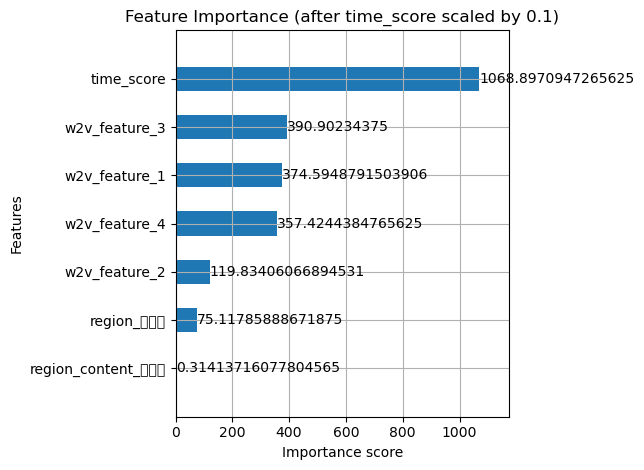

In [39]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plot_importance(model, max_num_features=20, importance_type='gain', height=0.5)
plt.title("Feature Importance (after time_score scaled by 0.1)")
plt.tight_layout()
plt.show()


In [40]:
# 기준 콘텐츠 (label==1 중 최고 점수)의 content_detail_id
top_liked = (
    merged_df[merged_df['label'] == 1]
    .sort_values(['member_id', 'score'], ascending=[True, False])
    .groupby('member_id')
    .first()
    .reset_index()
)

# 추천 결과 (label==0 중 score + similarity 기준 상위 콘텐츠)
top_recs = final_recommendations[['member_id', 'content_detail_id']]  # 이건 너가 실제 추천한 결과

# 기준 콘텐츠와 추천 콘텐츠를 중분류 ID 기준으로 join
ref_df = top_liked[['member_id', 'content_detail_id']].rename(columns={'content_detail_id': 'liked_id'})
ref_df = ref_df.merge(
    contents_df[['id', 'content_sub_category_id']], left_on='liked_id', right_on='id'
).rename(columns={'content_sub_category_id': 'liked_subcat'}).drop(columns='id')

rec_df = top_recs.merge(
    contents_df[['id', 'content_sub_category_id']], left_on='content_detail_id', right_on='id'
).rename(columns={'content_sub_category_id': 'rec_subcat'}).drop(columns='id')

# 두 데이터프레임 병합
compare_df = ref_df.merge(rec_df, on='member_id')

# 중분류가 같은지 여부
compare_df['same_subcat'] = compare_df['liked_subcat'] == compare_df['rec_subcat']

compare_df


,member_id,liked_id,liked_subcat,content_detail_id,rec_subcat,same_subcat
0,1,311,11,790,6,False
1,1,311,11,612,5,False
2,1,311,11,1254,5,False
3,2,138,8,254,12,False
4,2,138,8,1151,5,False
...,...,...,...,...,...,...
151,51,41,14,253,12,False
152,51,41,14,155,2,False
153,52,29,14,395,4,False
154,52,29,14,75,7,False


In [41]:
diff_ratio = (compare_df['same_subcat'] == False).mean()
print(f"중분류가 다른 경우의 비율: {diff_ratio:.2%}")


중분류가 다른 경우의 비율: 84.62%


In [42]:
# 추천 결과 저장
final_recommendations.to_csv("final_recommendations.csv", index=False)
